In [1]:
import torch_geometric
from torch_geometric.loader import DataLoader
from torch_geometric.datasets import MNISTSuperpixels
import matplotlib.pyplot as plt
import numpy as np
#sudo apt install -y freeglut3-dev libglib2.0-0
import cv2

/home/mancio/git/ebm-molecules/.venv/lib/python3.12/site-packages/torch_geometric/typing.py:68: UserWarning: An issue occurred while importing 'pyg-lib'. Disabling its usage. Stacktrace: /home/mancio/git/ebm-molecules/.venv/lib/python3.12/site-packages/libpyg.so: undefined symbol: _ZN5torch8autograd12VariableInfoC1ERKN2at6TensorE
  warnings.warn(f"An issue occurred while importing 'pyg-lib'. "


In [2]:
def superpixels_to_2d_image(rec: torch_geometric.data.Data, scale: int = 30, edge_width: int = 1) -> np.ndarray:
    pos = (rec.pos.clone() * scale).int()

    image = np.zeros((scale * 26, scale * 26, 1), dtype=np.uint8)
    for (color, (x, y)) in zip(rec.x, pos):
        x0, y0 = int(x), int(y)
        x1, y1 = x0 - scale, y0 - scale

        color = int(float(color + 0.15) * 255)
        color = min(color, 255)

        cv2.rectangle(image, (x0, y0), (x1, y1), color, -1)

    for node_ix_0, node_ix_1 in rec.edge_index.T:
        x0, y0 = list(map(int, pos[node_ix_0]))
        x1, y1 = list(map(int, pos[node_ix_1]))

        x0 -= scale // 2
        y0 -= scale // 2
        x1 -= scale // 2
        y1 -= scale // 2

        cv2.line(image, (x0, y0), (x1, y1), 125, edge_width)
    return image

In [3]:
mnist = MNISTSuperpixels(root="../datasets/MNISTSuperpixel")

In [7]:
dataLoader: DataLoader = DataLoader(mnist)

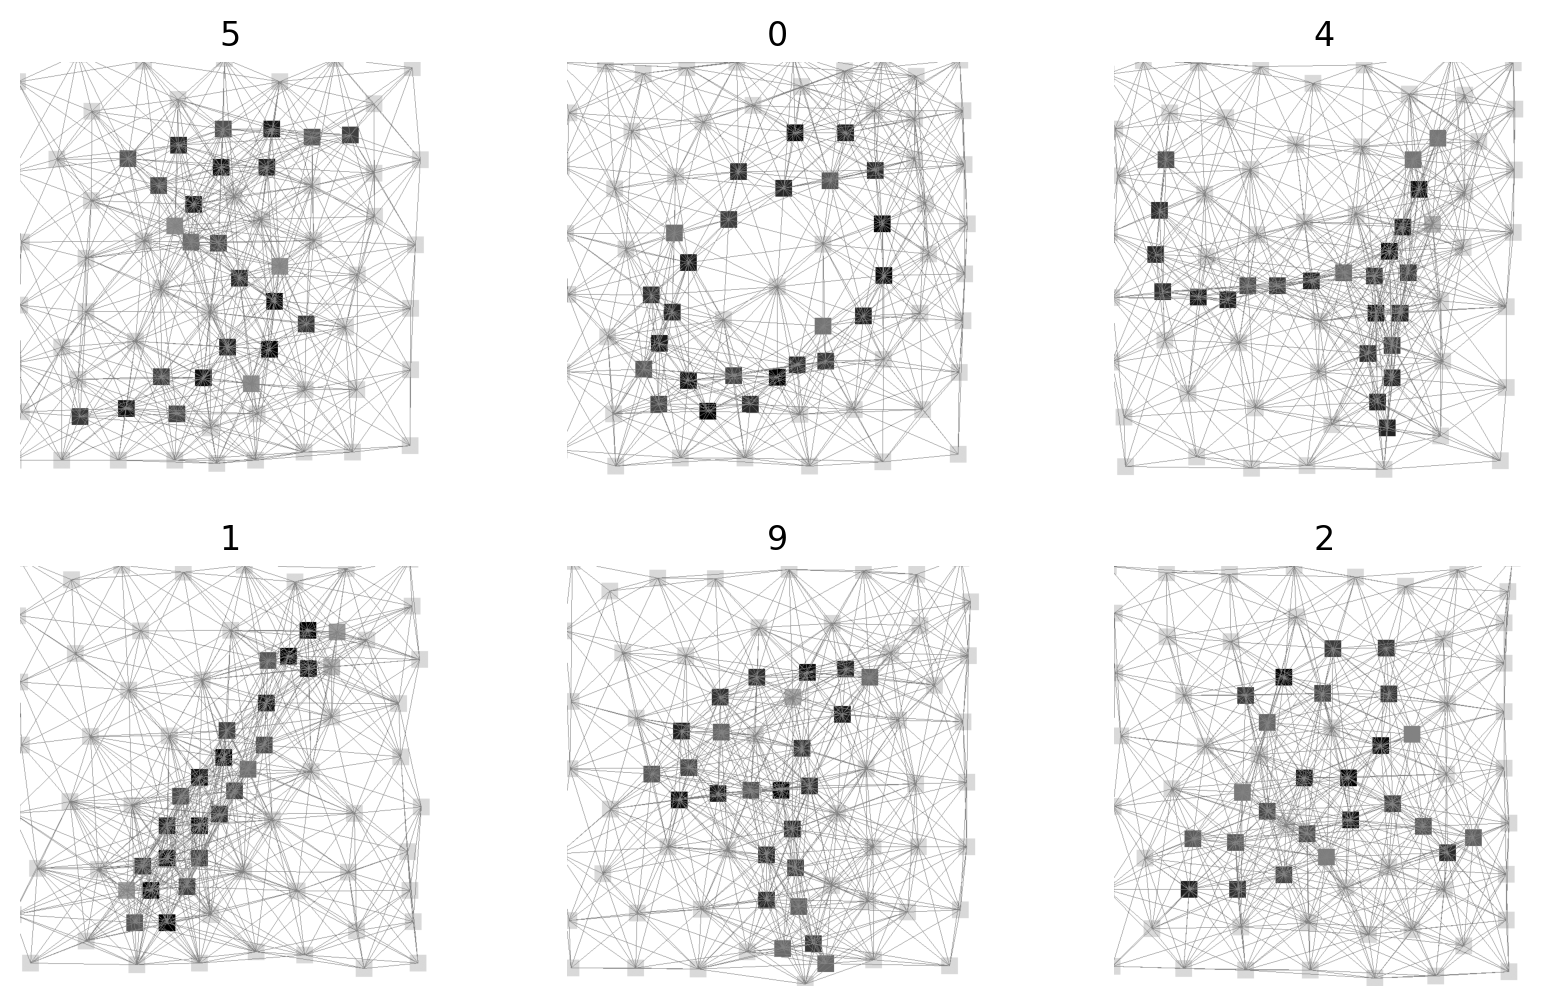

In [10]:
fig, axes = plt.subplots(2, 3, figsize=(10, 6), dpi=200)
axes = axes.flatten()
data_loader_iter = iter(dataLoader)
for i in range(len(axes)):
    data = next(data_loader_iter)
    image = superpixels_to_2d_image(data)
    axes[i].imshow(image, cmap=plt.cm.binary)
    axes[i].axis("off")
    axes[i].set_title(f"{data.y.item()}")
plt.show()

In [22]:
data = next(data_loader_iter)
print(data)
#print(data.x)
print(data.edge_index)

DataBatch(x=[75, 1], edge_index=[2, 1369], y=[1], pos=[75, 2], batch=[75], ptr=[2])
tensor([[ 0,  0,  0,  ..., 74, 74, 74],
        [ 1,  2,  3,  ..., 49, 50, 65]])
